## Previsão Ibovespa
Esse notebook tem como objetivo realizar a previsão do índice IBovespa utilizando alguns modelos de Machine Learning. Esse projeto foi realizado como parte da Fase 2 da pós graduação em Data Analytics da POSTECH FIAP.

### 1. Entendimento do Negócio
O problema
Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do 
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%)

### 2. Entendimento dos Dados
Para isso, utilize a base de dados contida no site da Investing https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado. 

Testaremos alguns períodos Históricos para treinamento com uso de 180 dias anteriores para previsão. 

## Importando Bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from datetime import datetime


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller




## Preparação dos Dados

Realizamos a leitura dos dados extraídos do site da Ibovespa para utilizá-los no notebook e realizar a Análise Exploratória dos Dados (EDA), conforme ilustrado na imagem abaixo

In [3]:
url = 'https://raw.githubusercontent.com/Data-Analitycs-Pos-Tech-Fiap/Ibovespa-prev/refs/heads/main/datasets/Dados%20Hist%C3%B3ricos%20-%20Ibovespa%202000%20a%202025.csv'

dados = pd.read_csv(url, sep=',', encoding='utf-8')

dados.head(10)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.01.2025,118.533,120.125,120.356,118.404,"9,80B","-1,33%"
1,02.01.2025,120.125,120.283,120.782,119.120,"9,37B","-0,13%"
2,30.12.2024,120.283,120.267,121.050,120.158,"8,90B","0,01%"
3,27.12.2024,120.269,121.078,121.609,120.252,"8,94B","-0,67%"
4,26.12.2024,121.078,120.767,121.612,120.428,"8,34B","0,26%"
5,23.12.2024,120.767,122.105,122.105,120.617,"9,95B","-1,09%"
6,20.12.2024,122.102,121.183,122.209,120.700,"18,13B","0,75%"
7,19.12.2024,121.188,120.768,121.770,120.768,"13,68B","0,34%"
8,18.12.2024,120.772,124.699,124.699,120.457,"19,74B","-3,15%"
9,17.12.2024,124.698,123.560,125.301,123.560,"17,56B","0,92%"


Ao verificar as informações dos dados e validar as colunas, observamos que a coluna "Data" está no formato "object" (string). Para realizar a análise e as previsões corretamente, é necessário converter essa coluna para o tipo datetime.

In [4]:
# compreendendo os tipos de dados e o shape da base
print(dados.info())
print('----------------------------------------------------')
print('TAMANHO DA BASE: ', dados.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.1+ KB
None
----------------------------------------------------
TAMANHO DA BASE:  (4954, 7)


In [5]:
dados.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

Realizamos a conversão da coluna "Data" para o tipo datetime e, em seguida, definimos essa coluna como índice, ordenando os dados. Após esse processo, reindexamos a série para uma frequência diária, utilizando o método ffill para preencher valores ausentes. Por fim, preenchemos os valores nulos nas demais colunas e resetamos o índice.

In [6]:
# Converter a coluna 'Data' para datetime
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y', errors='coerce')

# Definir 'Data' como índice e ordenar
dados = dados.set_index('Data').sort_index()

# Reindexar com frequência diária
dados = dados.asfreq('D', method='ffill')

# Preencher valores NaN nas outras colunas
for column in dados.columns:
    dados[column] = dados[column].fillna(method='ffill')

# Resetar o índice
dados.reset_index(inplace=True)

# Verificar o resultado
print(dados.head(10))


        Data  Último  Abertura  Máxima  Mínima     Vol.    Var%
0 2005-01-04  24.848    25.722  25.873  24.791  146,14M  -3,40%
1 2005-01-05  24.692    24.859  25.001  24.523  127,42M  -0,63%
2 2005-01-06  24.367    24.695  24.808  24.250  151,17M  -1,32%
3 2005-01-07  24.747    24.376  24.874  24.376  104,96M   1,56%
4 2005-01-08  24.747    24.376  24.874  24.376  104,96M   1,56%
5 2005-01-09  24.747    24.376  24.874  24.376  104,96M   1,56%
6 2005-01-10  24.292    24.747  24.825  24.086  126,23M  -1,84%
7 2005-01-11  24.370    24.295  24.457  24.127  111,40M   0,32%
8 2005-01-12  24.510    24.370  24.560  23.983  107,12M   0,57%
9 2005-01-13  24.806    24.523  24.919  24.523   91,08M   1,21%


C:\Users\kelvyn.candido\AppData\Local\Temp\ipykernel_21132\1433539146.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados[column] = dados[column].fillna(method='ffill')


Aqui podemos notar que a coluna data está como tipo datetime.

In [7]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      7305 non-null   datetime64[ns]
 1   Último    7305 non-null   float64       
 2   Abertura  7305 non-null   float64       
 3   Máxima    7305 non-null   float64       
 4   Mínima    7305 non-null   float64       
 5   Vol.      7305 non-null   object        
 6   Var%      7305 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 399.6+ KB


Aqui definimos uma nova coluna chamada unique id e renomeamos e selecionamos essas colunas.

In [8]:
# incluindo coluna categórica
dados['unique_id'] = 'ibovespa'

In [9]:
# renomeando colunas
dados = dados.rename(columns={'Data': 'ds', 'Último': 'y'})
# selecionando colunas
dados = dados[['ds', 'y', 'unique_id']]
dados.head(10)

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa
1,2005-01-05,24.692,ibovespa
2,2005-01-06,24.367,ibovespa
3,2005-01-07,24.747,ibovespa
4,2005-01-08,24.747,ibovespa
5,2005-01-09,24.747,ibovespa
6,2005-01-10,24.292,ibovespa
7,2005-01-11,24.370,ibovespa
8,2005-01-12,24.510,ibovespa
9,2005-01-13,24.806,ibovespa


In [10]:
# df com data como índice e valores só coluna y
df1 = dados[['ds', 'y']]
df1 = dados.set_index('ds')

In [11]:
dados.head(1)

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa


In [12]:
sns.set_style('darkgrid')

## Visualização Inicial

Utilizamos a biblioteca Matplotlib para plotar os dados do Ibovespa e analisar sua sazonalidade, o que nos permite compreender melhor o comportamento da bolsa durante esse período. Essa análise é essencial para uma interpretação mais aprofundada dos dados.  

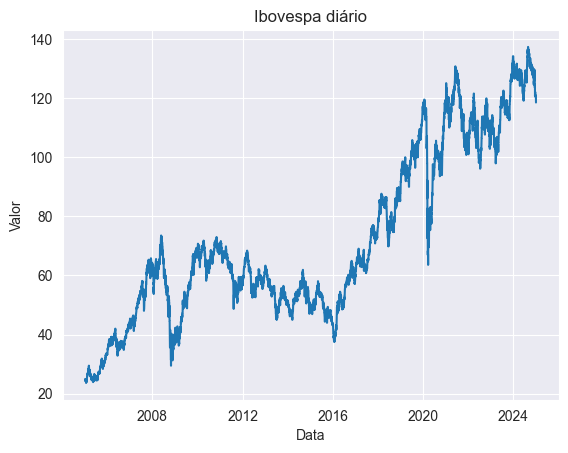

In [13]:
plt.plot(df1.index, df1["y"])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Ibovespa diário')
plt.show()

Neste processo, utilizamos a função seasonal_decompose para decompor a série temporal em suas componentes: sazonalidade, tendência e ruído (ou residual), como mostrado na imagem abaixo:  

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
resultados = seasonal_decompose(df1['y'], model='additive', period=365)


Esse tipo de decomposição é útil para entender melhor a estrutura da série temporal e identificar padrões.

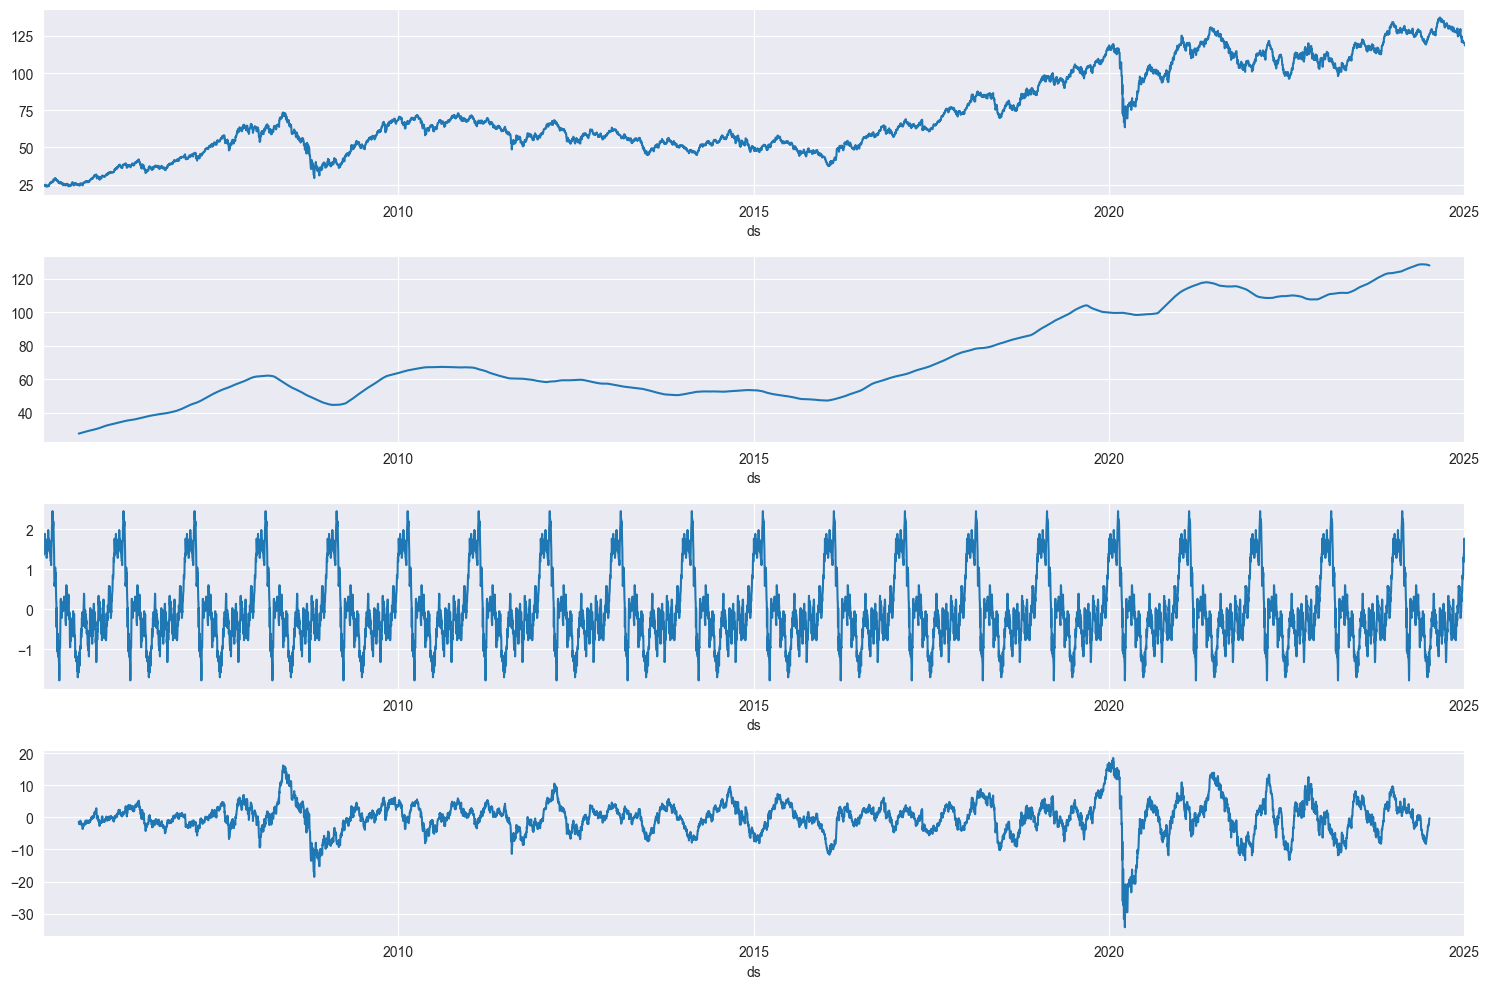

In [15]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# mostrando a série do data frame
resultados.observed.plot(ax=ax1)
# mostrando a tendência dos dados
resultados.trend.plot(ax=ax2)
# mostrando a sazonalidade - constante e recorrente
resultados.seasonal.plot(ax=ax3)
# mostrando os resíduos
resultados.resid.plot(ax=ax4)

plt.tight_layout()

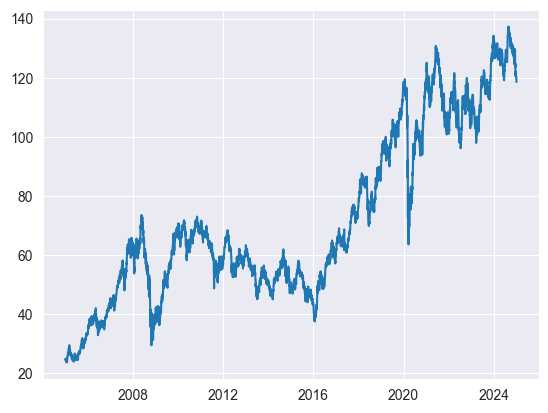

In [16]:
plt.plot(df1.index, df1.y)

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
X = df1.y.values

## Testes estatísticos

Aplicamos o teste de Dickey-Fuller Aumentado (ADF) com o objetivo de verificar sua estacionariedade. Uma série é considerada estacionária quando sua média e variância permanecem constantes ao longo do tempo. Caso contrário, a série é considerada não estacionária. Se o valor do teste estatístico for maior que os valores críticos e o p-value for alto (superior a 0,05), isso indica que não podemos rejeitar a hipótese nula de que a série é não estacionária

In [19]:
result = adfuller(X)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.4581585591306807
P-Value: 0.5540989239281978
Valores críticos:
	1%: -3.4312474625349556
	5%: -2.8619366088117606
	10%: -2.5669811106290608


In [20]:
df1.shape

(7305, 2)

## Analise de tendência

Nesta análise, calculamos a média móvel utilizando uma janela de 365 dias para observar o comportamento dos dados ao longo do tempo. Através dessa média, podemos identificar uma tendência de crescimento nos dados.  

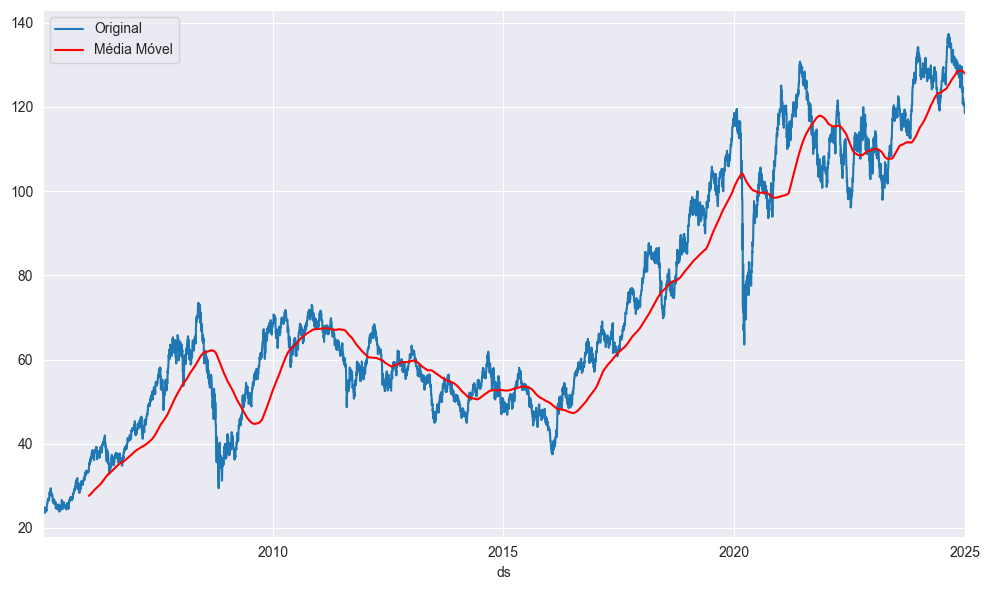

In [21]:
# Calcular média móvel com janela menor
ma = df1['y'].rolling(window=365).mean()

# Criar o gráfico
f, ax = plt.subplots(figsize=(10,6))
df1['y'].plot(ax=ax, label='Original')
ma.plot(ax=ax, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()




In [22]:
df1 = df1.reset_index().rename(columns={'index': 'ds'})

Neste gráfico, visualizamos a evolução da Bolsa de Valores ao longo do tempo, com o objetivo de identificar os principais eventos que impactaram o mercado. O período analisado destaca eventos externos significativos, como a crise imobiliária nos Estados Unidos em 2008, o impeachment do presidente Dilma em 2016 e a pandemia de Covid-19 em 2020. Esses fatores desempenharam um papel crucial nas quedas observadas na Bolsa de Valores durante esses anos específicos.

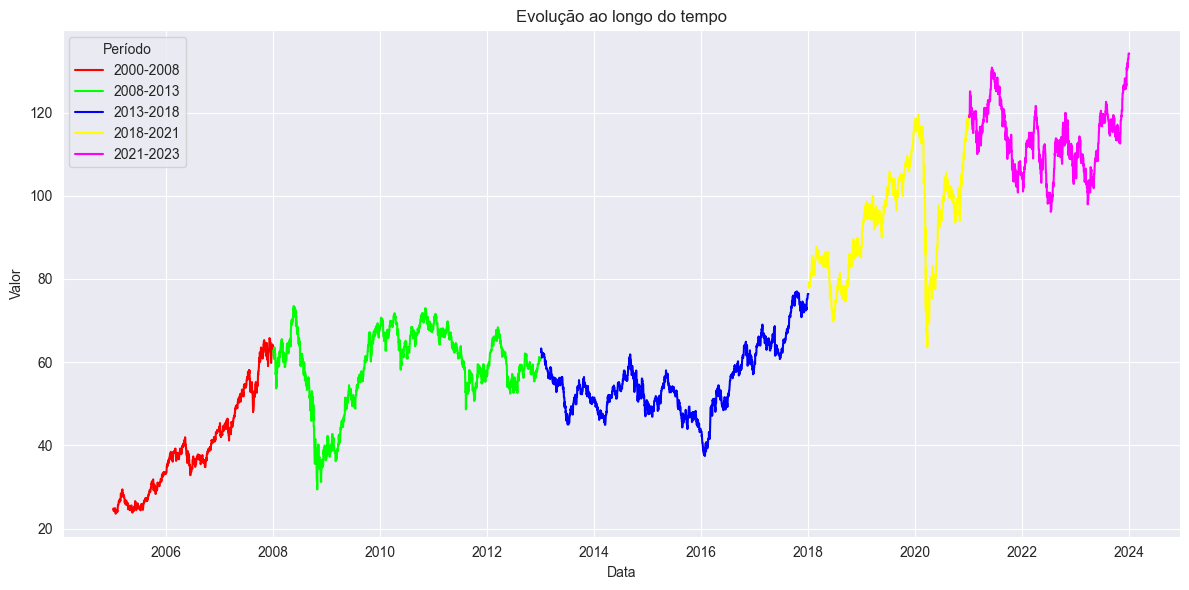

In [23]:

plt.figure(figsize=(12, 6))

# Definir as datas de corte
cut_dates = [
    datetime(2000, 1, 1),
    datetime(2008, 1, 1),
    datetime(2013, 1, 1),
    datetime(2018, 1, 1),
    datetime(2021, 1, 1),
    datetime(2023, 12, 31)
]

# Criar uma paleta de cores
colors = sns.color_palette(["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF"])

# Plotar cada linha
for i in range(len(cut_dates) - 1):
    mask = (df1['ds'] > cut_dates[i]) & (df1['ds'] <= cut_dates[i+1])
    sns.lineplot(
        data=df1[mask],
        x='ds',
        y='y',
        color=colors[i],
        label=f'{cut_dates[i].year}-{cut_dates[i+1].year}'
    )

# Configurar o gráfico
plt.title('Evolução ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend(title='Período')

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


## Preparação para Modelagem

O código abaixo pega um conjunto de dados e o divide em duas partes: uma para treinar um modelo de machine learning e outra para testar a performance desse modelo.

In [24]:
def split_train_test(df, start_date, test_ratio=0.2):
    # Filtra o DataFrame para incluir apenas dados a partir da data de início especificada
    df_period = df[df['ds'] >= start_date]

    # Calcula o índice de corte com base na proporção de teste
    cutoff_index = int(len(df_period) * (1 - test_ratio))

    # Cria o conjunto de treino com dados até o índice de corte (exclusive)
    df_train = df_period.iloc[:cutoff_index]

    # Cria o conjunto de teste com dados a partir do índice de corte
    df_test = df_period.iloc[cutoff_index:]

    # Retorna os conjuntos de treino e teste
    return df_train, df_test

A análise da evolução temporal dos dados é realizada através da segmentação da série histórica em múltiplos períodos, proporcionando uma visão detalhada do comportamento do Ibovespa ao longo do tempo. Esta abordagem permite a criação de visualizações específicas para cada intervalo, oferecendo insights valiosos sobre as tendências e padrões do mercado financeiro brasileiro.

Ao dividir os dados em conjuntos de treino e teste para diferentes períodos, obtemos uma perspectiva mais abrangente da capacidade de generalização dos modelos preditivos. Esta técnica é fundamental para avaliar a robustez e a consistência das previsões em diversos contextos temporais.

A comparação entre as linhas de treino e teste em cada visualização serve como um indicador crucial da eficácia do modelo. Uma correspondência próxima entre essas linhas sugere que o modelo mantém sua precisão preditiva mesmo quando aplicado a dados de períodos distintos daqueles utilizados em seu treinamento. Por outro lado, discrepâncias significativas podem indicar a necessidade de ajustes no modelo ou a presença de mudanças estruturais no comportamento do mercado ao longo do tempo.

Esta metodologia de análise não apenas contribui para a validação da performance do modelo, mas também oferece uma compreensão mais profunda das dinâmicas do Ibovespa em diferentes épocas. Tal entendimento é essencial para investidores e analistas de mercado, permitindo-lhes tomar decisões mais informadas e estratégicas.

In [25]:
start_dates = [
    pd.Timestamp('2000-01-01'),  # Desde o início da série histórica
    pd.Timestamp('2008-01-01'),  # Últimos 15 anos
    pd.Timestamp('2013-01-01'),  # Últimos 10 anos
    pd.Timestamp('2018-01-01'),  # Últimos 5 anos
    pd.Timestamp('2021-01-01')   # Últimos 3 anos
]


A função split_train_test é projetada para dividir um conjunto de dados temporais de forma flexível e eficiente. Ela utiliza um parâmetro start_date, que permite ao usuário especificar dinamicamente o ponto de início para a análise. Esta abordagem oferece versatilidade na seleção do período de interesse.

A função opera da seguinte maneira:

Filtra o DataFrame para incluir apenas dados a partir da data de início fornecida.
Calcula o ponto de divisão entre os conjuntos de treino e teste, baseado na proporção especificada (padrão de 20% para teste).

Separa os dados em conjuntos de treino e teste.

In [26]:
dfs = [split_train_test(df1, start_date) for start_date in start_dates]

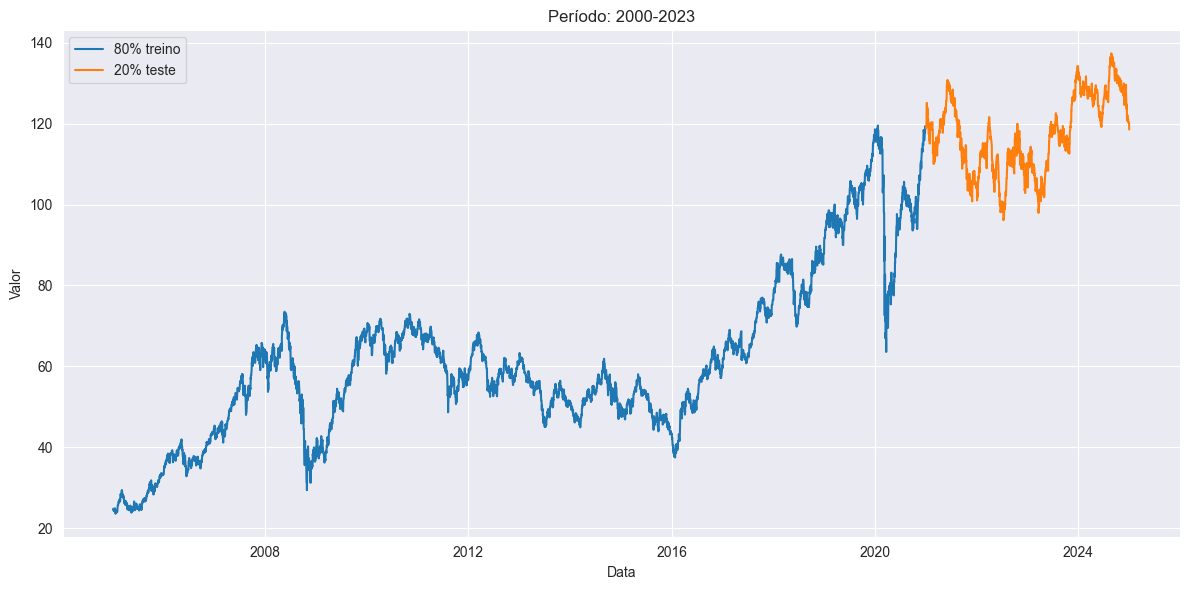

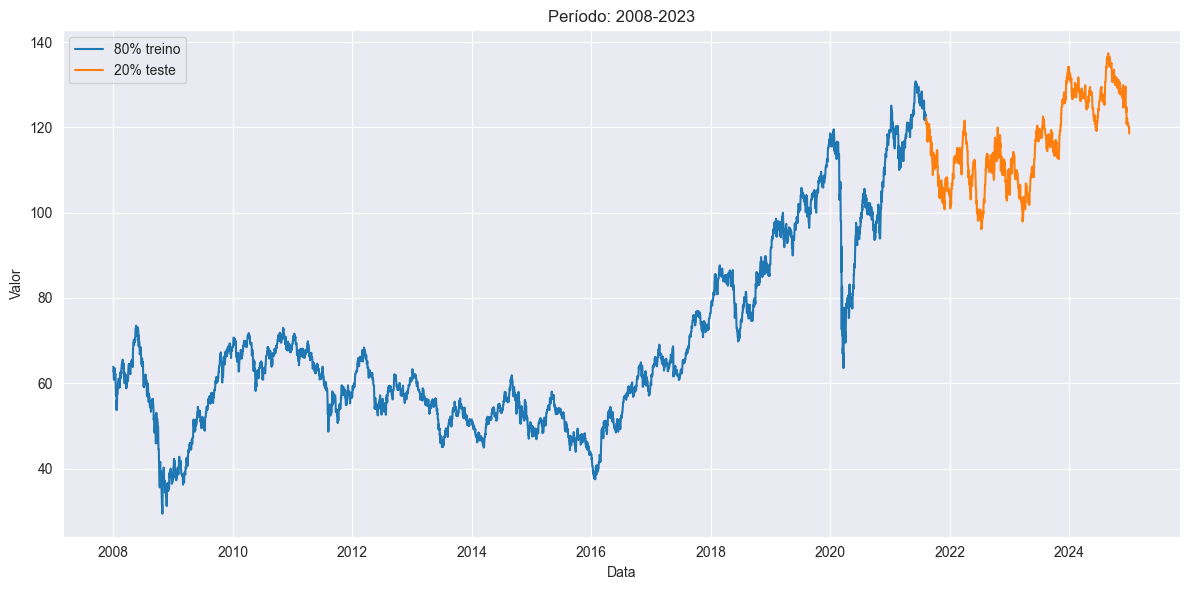

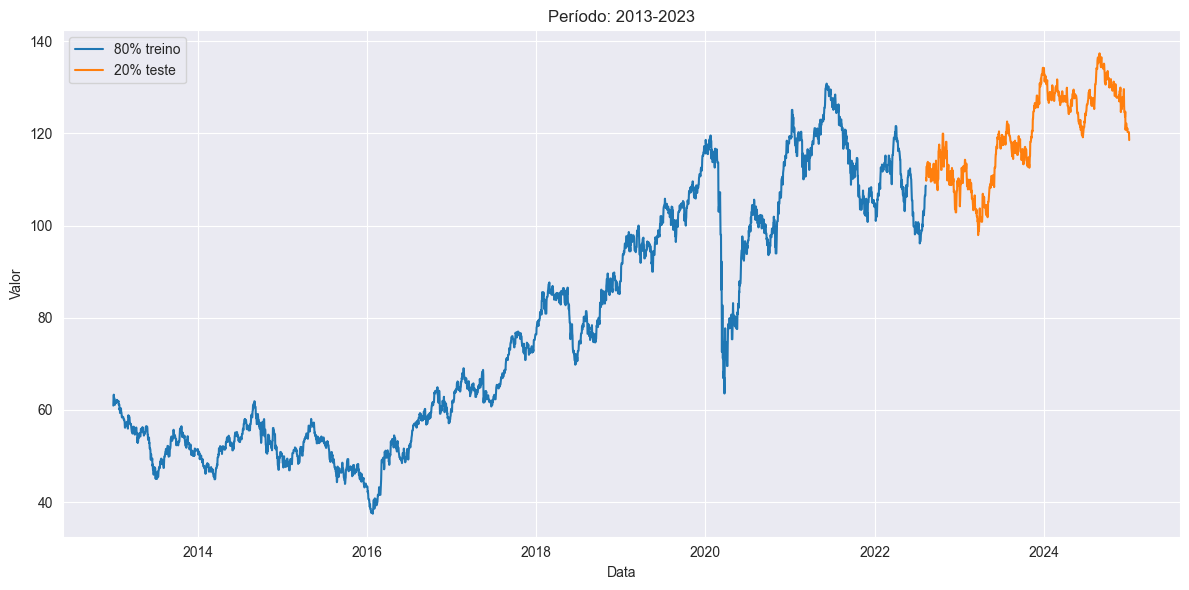

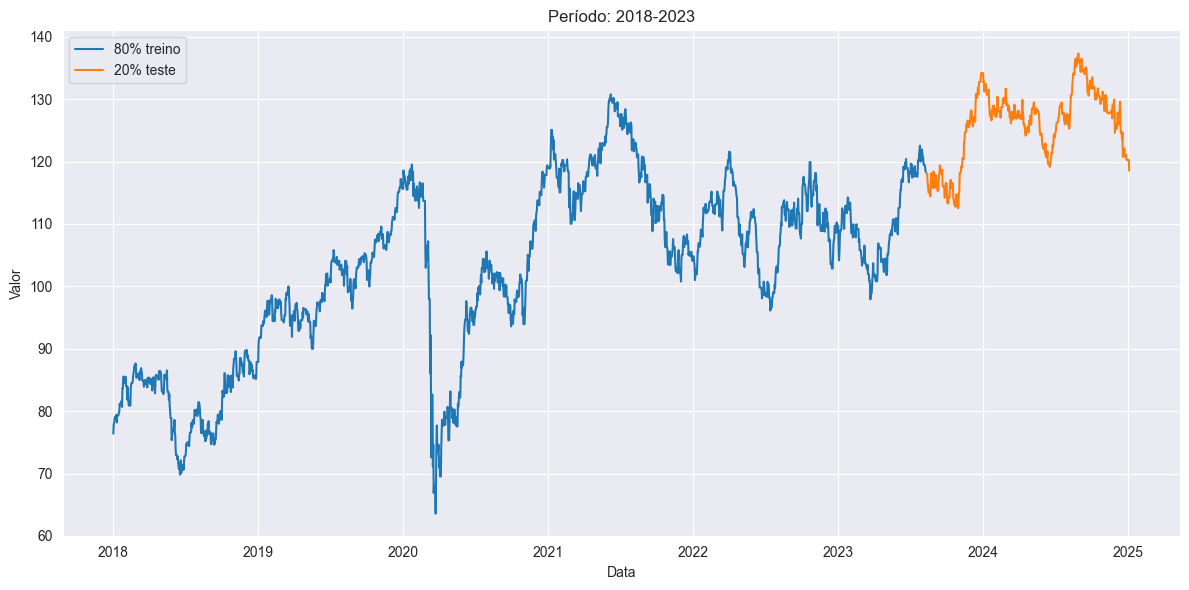

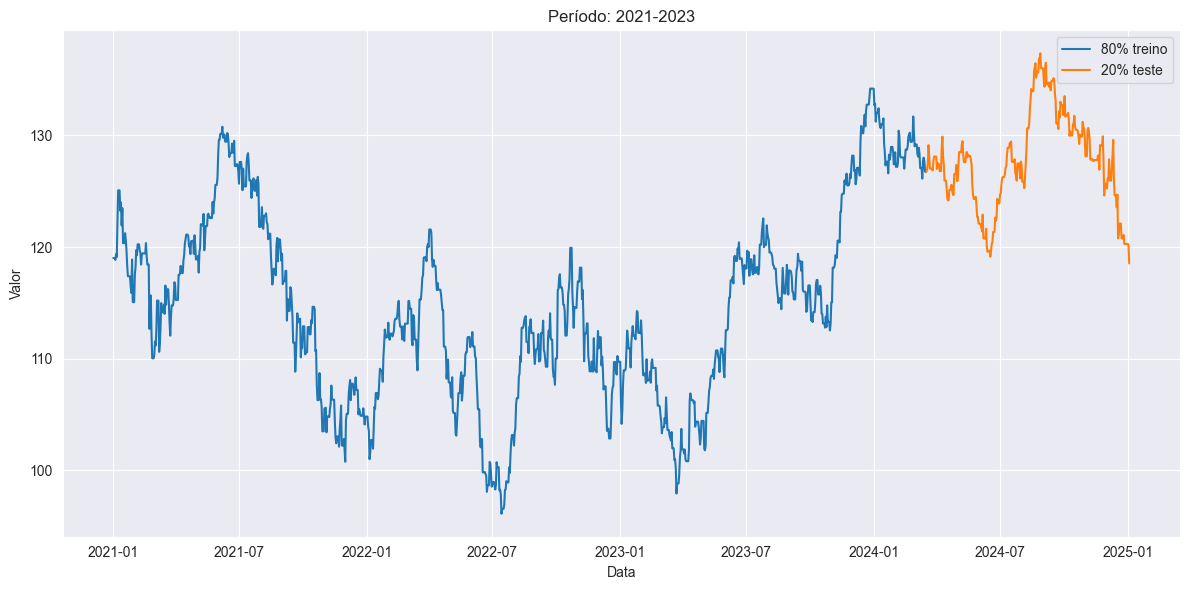

In [27]:
for i, (df_train, df_test) in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df_train, x='ds', y='y', label='80% treino', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='20% teste', ax=ax)
    
    ax.set_title(f'Período: {start_dates[i].year}-2023')
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [28]:
# Verificar o DataFrame df1
print("Informações do DataFrame:")
print(df1.info())
print("\nPrimeiras linhas do DataFrame:")
print(df1.head())

# Verificar a série da média móvel
print("\nInformações da média móvel:")
print(ma.head())
print("\nVerificar valores nulos na média móvel:")
print(ma.isnull().sum())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         7305 non-null   datetime64[ns]
 1   y          7305 non-null   float64       
 2   unique_id  7305 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 171.3+ KB
None

Primeiras linhas do DataFrame:
          ds       y unique_id
0 2005-01-04  24.848  ibovespa
1 2005-01-05  24.692  ibovespa
2 2005-01-06  24.367  ibovespa
3 2005-01-07  24.747  ibovespa
4 2005-01-08  24.747  ibovespa

Informações da média móvel:
ds
2005-01-04   NaN
2005-01-05   NaN
2005-01-06   NaN
2005-01-07   NaN
2005-01-08   NaN
Name: y, dtype: float64

Verificar valores nulos na média móvel:
364


## Transformações Adicionais 

O código executa uma análise preliminar eficiente de uma série temporal, focando em duas transformações principais:

1. Conversão logarítmica: Aplica o logaritmo natural aos valores da série, o que ajuda a estabilizar a variância e linearizar tendências exponenciais.

2. Cálculo da média móvel: Utiliza uma janela de 365 dias para suavizar flutuações de curto prazo e revelar tendências de longo prazo.
Estas transformações são cruciais para:

- Identificar padrões subjacentes na série temporal
- Avaliar a estacionariedade dos dados
- Guiar a seleção de modelos preditivos apropriados

A visualização gráfica resultante permite uma comparação direta entre a série logarítmica e sua média móvel, facilitando a detecção de tendências, sazonalidades e possíveis anomalias

In [29]:
print(df1.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


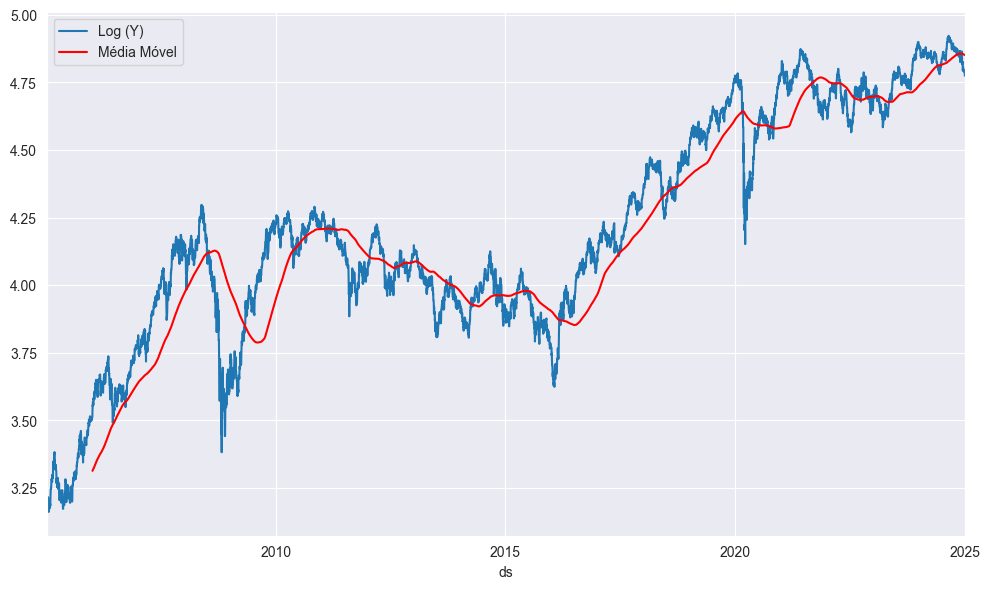

In [30]:
#selecionando somente as colunas ds e y, pois não são objetos
df_select = df1[['ds', 'y']]
# aplica a função logaritmo na coluna y
df_select['y_log'] = np.log(df_select['y'])
#calcular a media móvel
df_select['ma_log'] = df_select['y_log'].rolling(window=365).mean()
# Plotar o gráfico
f, ax = plt.subplots(figsize=(10,6))
# série logarítmica
df_select.plot(x ='ds', y='y_log',ax=ax, legend=False, label='Log (Y)')
df_select.plot(x='ds', y='ma_log', ax=ax, color='r', legend=False, label='Média Móvel')  # Média móvel
# Ajustar layout e adicionar legenda
plt.legend()
plt.tight_layout()
plt.show()

O código abaixo executa o teste de raiz unitária de Augmented Dickey-Fuller (ADF) para avaliar a estacionariedade da série temporal.

In [31]:
serie_teste = df_select['y_log'].dropna()
resultado = adfuller(serie_teste)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária

print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print("Valores críticos:")

for key, value in resultado[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.161685935126042
P-Value: 0.22044384081142887
Valores críticos:
	1%: -3.431249066593906
	5%: -2.861937317574143
	10%: -2.566981487914207


### A interpretação dos resultados acima revela:

O teste estatístico (-2.1617) é maior que todos os valores críticos, indicando que não há evidência suficiente para rejeitar a hipótese nula de não-estacionariedade.

O p-value (0.2204) é consideravelmente maior que o nível de significância padrão de 0.05, corroborando a conclusão de não rejeitar a hipótese nula.

Estas evidências sugerem fortemente que a série temporal em questão não é estacionária. A não-estacionariedade implica que as propriedades estatísticas da série, como média e variância, não são constantes ao longo do tempo.

In [32]:
print(df_select.dtypes)
print(df_select.head(5))

ds        datetime64[ns]
y                float64
y_log            float64
ma_log           float64
dtype: object
          ds       y     y_log  ma_log
0 2005-01-04  24.848  3.212777     NaN
1 2005-01-05  24.692  3.206479     NaN
2 2005-01-06  24.367  3.193230     NaN
3 2005-01-07  24.747  3.208704     NaN
4 2005-01-08  24.747  3.208704     NaN


Conclusão
Os resultados indicam que a série não é estacionária. Isso significa que o modelo ARIMA, ou outro baseado em séries temporais, terá dificuldades em capturar padrões adequados sem primeiro tornar a série estacionária.



Transformando a série em estácionária.

In [33]:
# Aplicar diferenciação na série log-transformada
df_select['y_log_diff'] = df_select['y_log'].diff().dropna()

# Repetir o teste ADF para a série diferenciada
serie_teste_diff = df_select['y_log_diff'].dropna()
resultado_diff = adfuller(serie_teste_diff)

print("Teste ADF para Série Diferenciada:")
print(f"Estatística ADF: {resultado_diff[0]}")
print(f"P-Valor: {resultado_diff[1]}")
print("Valores Críticos:")
for key, value in resultado_diff[4].items():
    print(f"  {key}: {value}")


Teste ADF para Série Diferenciada:
Estatística ADF: -15.521322813652812
P-Valor: 2.281577230772133e-28
Valores Críticos:
  1%: -3.431249066593906
  5%: -2.861937317574143
  10%: -2.566981487914207


O gráfico apresentado ilustra uma série temporal que passou por duas transformações sequenciais: logarítmica e diferenciação. Estas operações são fundamentais na análise de séries temporais financeiras, como o Ibovespa, por várias razões:

1. Transformação logarítmica:
- Estabiliza a variância da série, reduzindo a heteroscedasticidade
- Lineariza tendências exponenciais, facilitando a análise
- Torna as mudanças percentuais mais evidentes
2. Diferenciação:
- Remove tendências lineares, tornando a série mais estacionária
- Elimina a dependência temporal, crucial para muitos modelos estatísticos
- Destaca mudanças de curto prazo na série

O resultado destas transformações é uma série que tende a oscilar em torno de zero, com amplitude relativamente constante. Esta característica é indicativa de estacionariedade, uma propriedade desejável que implica:

- Média constante ao longo do tempo
- Variância constante ao longo do tempo
- Autocorrelação independente do tempo

A estacionariedade é essencial para a aplicação de muitos modelos de séries temporais, como o ARIMA, pois permite previsões mais confiáveis e interpretáveis. Além disso, facilita a identificação de padrões cíclicos ou sazonais que podem estar ocultos na série original.

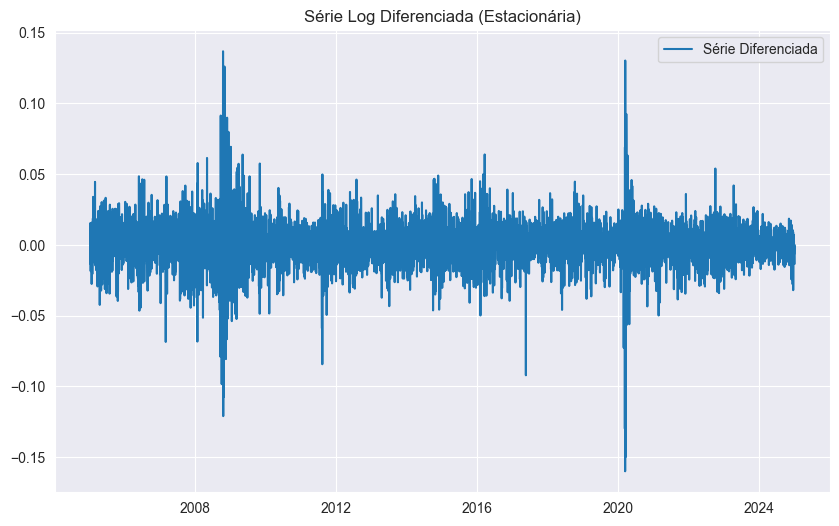

In [34]:
# Visualização da série diferenciada
plt.figure(figsize=(10, 6))
plt.plot(df_select['ds'], df_select['y_log_diff'], label='Série Diferenciada')
plt.title('Série Log Diferenciada (Estacionária)')
plt.legend()
plt.show()


## Modelagem e Previsão

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar o modelo ARIMA
model = ARIMA(df_select['y_log'], order=(1, 1, 1))  # p=1 nº de períodos defasados
                                                    # d=1 nº diferenciação
                                                    # q=1 ordem da média móvel
model_fit = model.fit()

# Resumo do modelo
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  y_log   No. Observations:                 7305
Model:                 ARIMA(1, 1, 1)   Log Likelihood               20947.305
Date:                Sat, 25 Jan 2025   AIC                         -41888.610
Time:                        12:49:40   BIC                         -41867.921
Sample:                             0   HQIC                        -41881.496
                               - 7305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1130      0.109     -1.034      0.301      -0.327       0.101
ma.L1          0.0688      0.110      0.626      0.531      -0.147       0.284
sigma2         0.0002    1.1e-06    172.473      0.0

### Indicadores de Ajuste Positivos
Os valores relativamente baixos de AIC (Critério de Informação de Akaike), BIC (Critério de Informação Bayesiano) e HQIC (Critério de Informação de Hannan-Quinn) sugerem um bom ajuste do modelo aos dados. Estes critérios avaliam o equilíbrio entre a complexidade do modelo e sua capacidade de explicar os dados, com valores menores indicando um ajuste mais adequado.

### Preocupações com os Resíduos
Apesar do bom ajuste geral, os testes de diagnóstico dos resíduos apresentam resultados preocupantes:
- Teste de Ljung-Box: Indica que os resíduos podem não ser independentes, sugerindo a presença de autocorrelação não capturada pelo modelo.
- Teste de Jarque-Bera: Sugere que os resíduos podem não seguir uma distribuição normal, violando uma das premissas do modelo ARIMA.

### Estratégia de Avaliação
Mesmo com estas inconsistências nos resíduos, a decisão de prosseguir com as previsões e comparar o ARIMA com outros modelos é acertada por várias razões:
- Permite uma avaliação comparativa do desempenho preditivo real do modelo.
- Oferece insights sobre a robustez do ARIMA em face de violações de premissas.
- Facilita a identificação do modelo mais adequado para este conjunto de dados específico.

### Próximos Passos
1. Realizar previsões com o modelo ARIMA atual.
2. Comparar as previsões do ARIMA com outros modelos, como Naive e Prophet.
3. Avaliar métricas de desempenho como MAE, WMAPE e acurácia para cada modelo.
4. Considerar ajustes no modelo ARIMA ou explorar modelos alternativos que possam lidar melhor com as características específicas dos dados.

## Previsões

In [36]:
# Fazer previsão para o próximo dia (em escala log)
forecast = model_fit.forecast(steps=1)
print("Previsão para o próximo dia (log):", forecast)

# Reverter o log para voltar à escala original
forecast_original = np.exp(forecast)
print("Previsão para o próximo dia (valor original):", forecast_original)


Previsão para o próximo dia (log): 7305    4.775776
dtype: float64
Previsão para o próximo dia (valor original): 7305    118.602353
dtype: float64


Validar o modelo

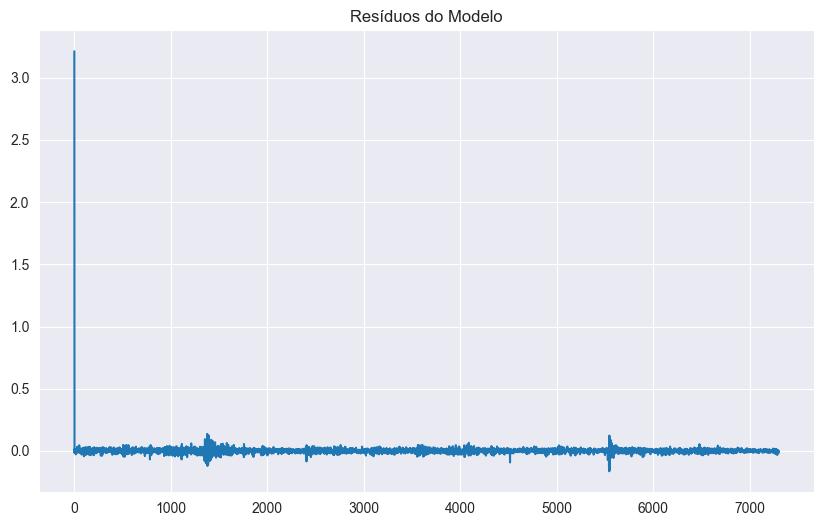

In [37]:
residuos = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuos)
plt.title("Resíduos do Modelo")
plt.show()


Comparação com dadods reais

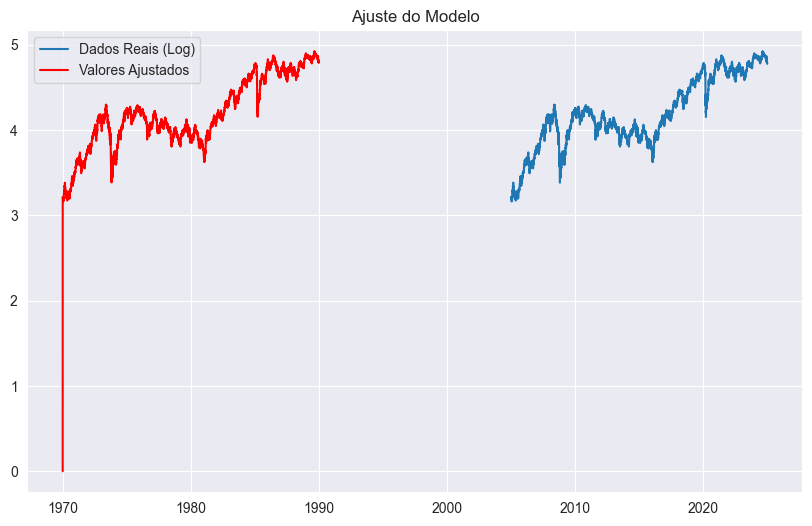

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(df_select['ds'], df_select['y_log'], label='Dados Reais (Log)')
plt.plot(model_fit.fittedvalues, color='red', label='Valores Ajustados')
plt.legend()
plt.title('Ajuste do Modelo')
plt.show()


Iteração 1
MAE: 8.03
Acurácia (Percentual de Previsão): 93.15%
WMAPE: 6.85%
------------------------------
Previsão para o próximo dia (Naive): 119.02


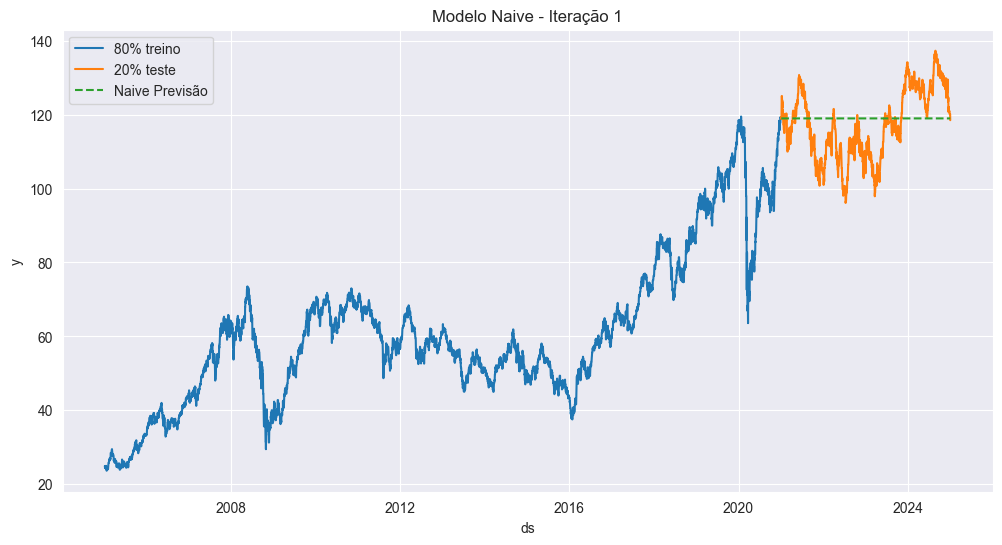

Iteração 2
MAE: 9.99
Acurácia (Percentual de Previsão): 91.43%
WMAPE: 8.57%
------------------------------
Previsão para o próximo dia (Naive): 123.02


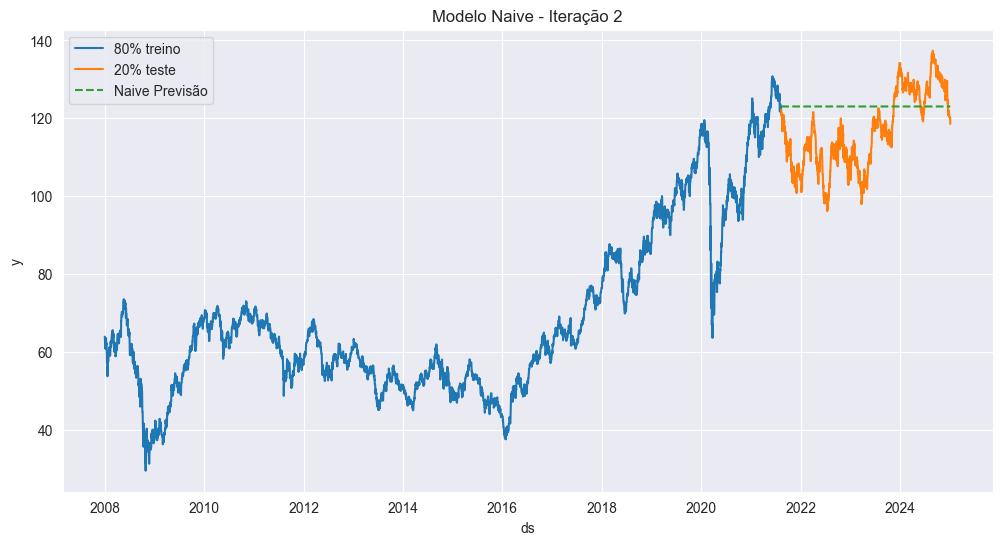

Iteração 3
MAE: 12.03
Acurácia (Percentual de Previsão): 89.94%
WMAPE: 10.06%
------------------------------
Previsão para o próximo dia (Naive): 108.65


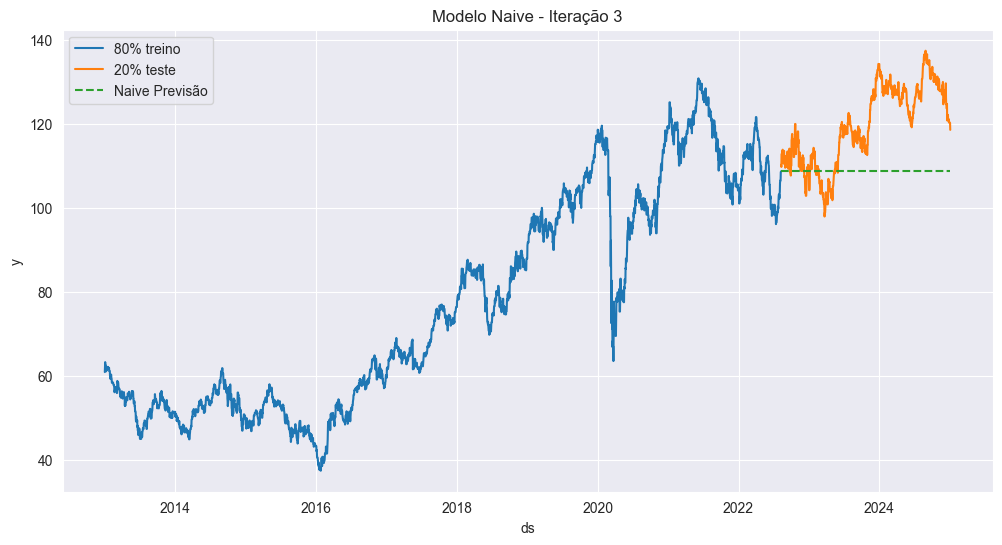

Iteração 4
MAE: 8.36
Acurácia (Percentual de Previsão): 93.36%
WMAPE: 6.64%
------------------------------
Previsão para o próximo dia (Naive): 118.35


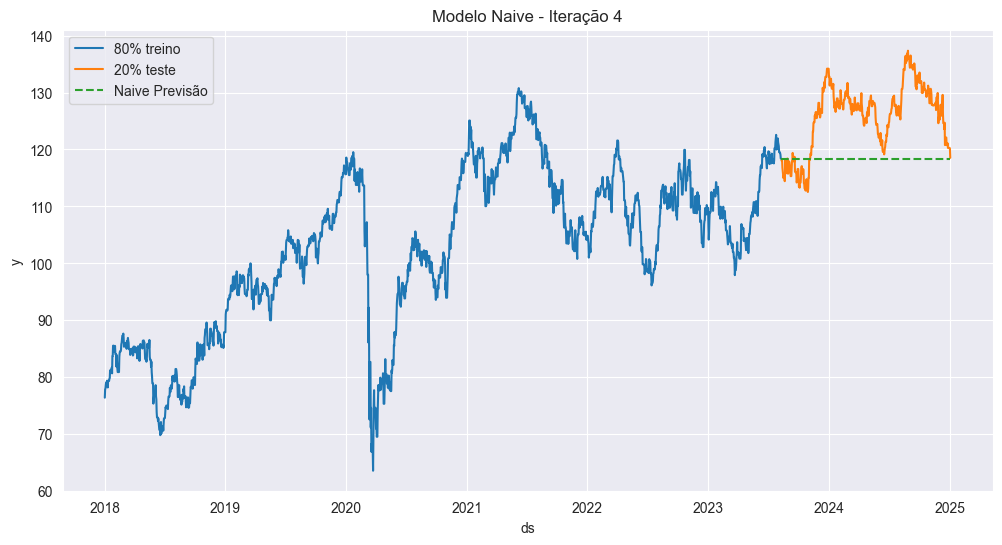

Iteração 5
MAE: 3.41
Acurácia (Percentual de Previsão): 97.33%
WMAPE: 2.67%
------------------------------
Previsão para o próximo dia (Naive): 126.74


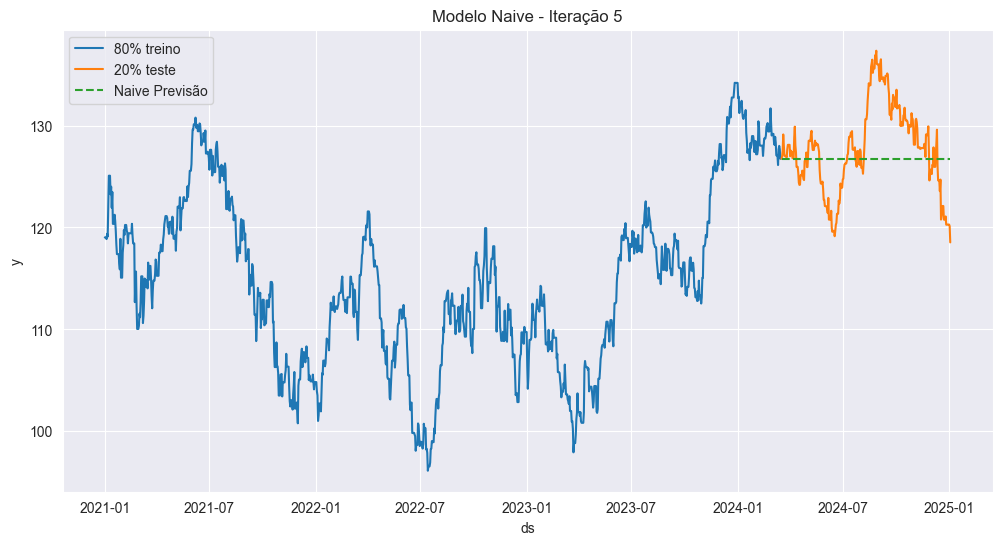

In [48]:
from sklearn.metrics import mean_absolute_error

# Iteração sobre os conjuntos de treino e teste
for i, (df_train, df_test) in enumerate(dfs):
    # Determinar o último valor observado no treino
    last_observed = df_train['y'].iloc[-1]
    
    # Criar previsões para o conjunto de teste usando o modelo Naive
    df_test['naive_forecast'] = last_observed  # Adiciona uma coluna para as previsões
    
    # Calcular o MAE
    mae = mean_absolute_error(df_test['y'], df_test['naive_forecast'])
    
    # Calcular a Acurácia (Percentual de Previsão)
    media_real = df_test['y'].mean()
    acuracia = (1 - (mae / media_real)) * 100
    
    # Calcular o WMAPE
    wmape = (np.sum(np.abs(df_test['y'] - df_test['naive_forecast'])) / np.sum(df_test['y'])) * 100
    
    # Exibir as métricas para a iteração atual
    print(f"Iteração {i+1}")
    print(f"MAE: {mae:.2f}")
    print(f"Acurácia (Percentual de Previsão): {acuracia:.2f}%")
    print(f"WMAPE: {wmape:.2f}%")
    print("-" * 30)
     # Exibir o número da previsão
    print(f"Previsão para o próximo dia (Naive): {df_test['naive_forecast'].iloc[-1]:.2f}")
    # Configurar o gráfico
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plotar os dados de treino, teste e previsões Naive
    sns.lineplot(data=df_train, x='ds', y='y', label='80% treino', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='20% teste', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='naive_forecast', label='Naive Previsão', linestyle='--', ax=ax)
    
    # Adicionar título e legendas
    ax.set_title(f'Modelo Naive - Iteração {i+1}')
    ax.legend()
    plt.show()


Iteração 1
Naive - MAE: 8.03, Acurácia: 93.15%, WMAPE: 6.85%
ARIMA - MAE: 8.03, Acurácia: 93.15%, WMAPE: 6.85%
--------------------------------------------------
Previsão para o próximo dia (Naive): 119.02
Previsão para o próximo dia (ARIMA): 119.02


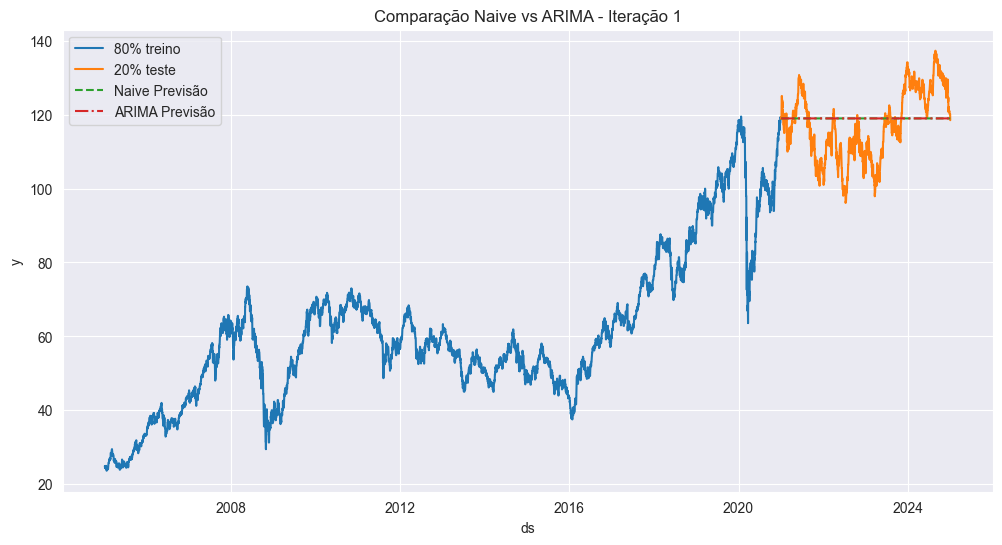

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 2
Naive - MAE: 9.99, Acurácia: 91.43%, WMAPE: 8.57%
ARIMA - MAE: 9.99, Acurácia: 91.43%, WMAPE: 8.57%
--------------------------------------------------
Previsão para o próximo dia (Naive): 123.02
Previsão para o próximo dia (ARIMA): 123.00


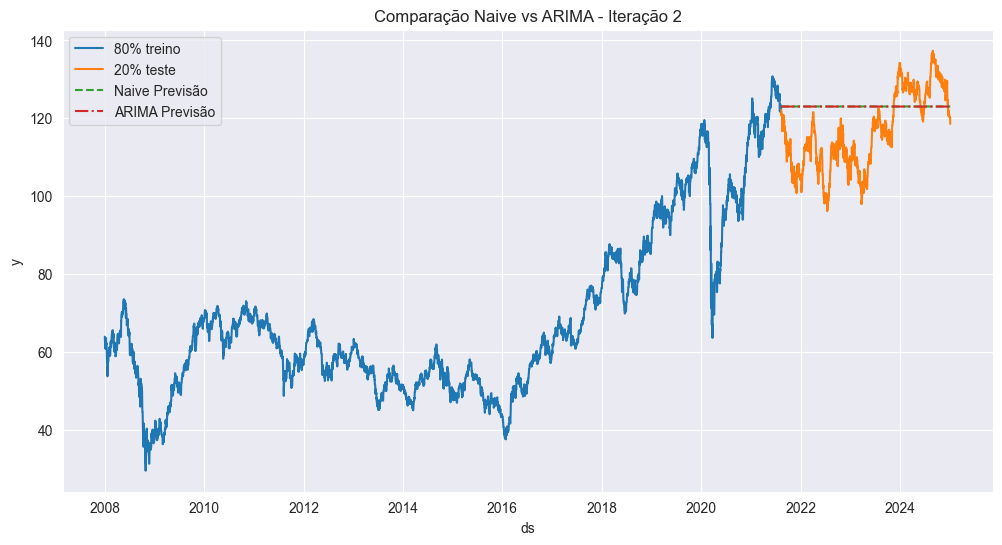

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 3
Naive - MAE: 12.03, Acurácia: 89.94%, WMAPE: 10.06%
ARIMA - MAE: 12.06, Acurácia: 89.92%, WMAPE: 10.08%
--------------------------------------------------
Previsão para o próximo dia (Naive): 108.65
Previsão para o próximo dia (ARIMA): 108.61


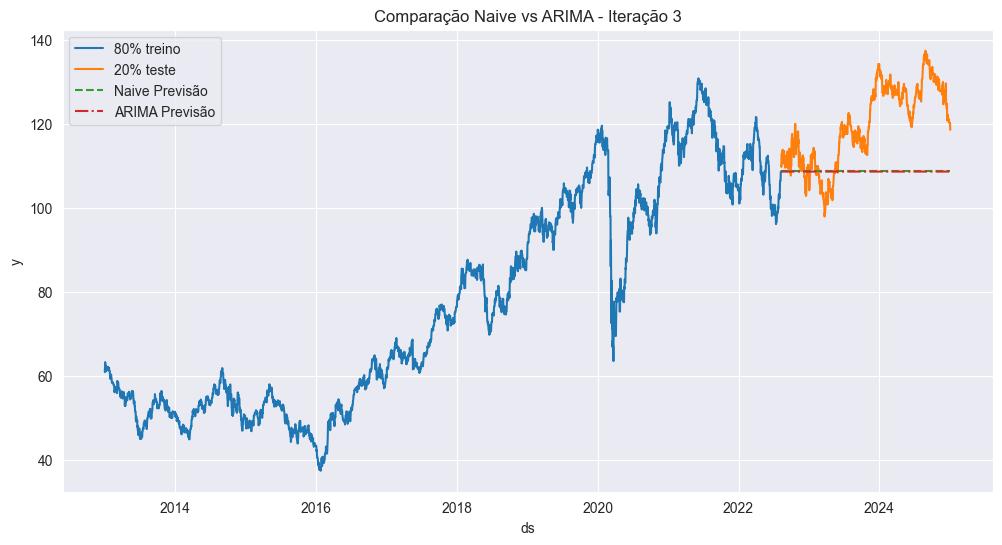

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 4
Naive - MAE: 8.36, Acurácia: 93.36%, WMAPE: 6.64%
ARIMA - MAE: 8.35, Acurácia: 93.36%, WMAPE: 6.64%
--------------------------------------------------
Previsão para o próximo dia (Naive): 118.35
Previsão para o próximo dia (ARIMA): 118.36


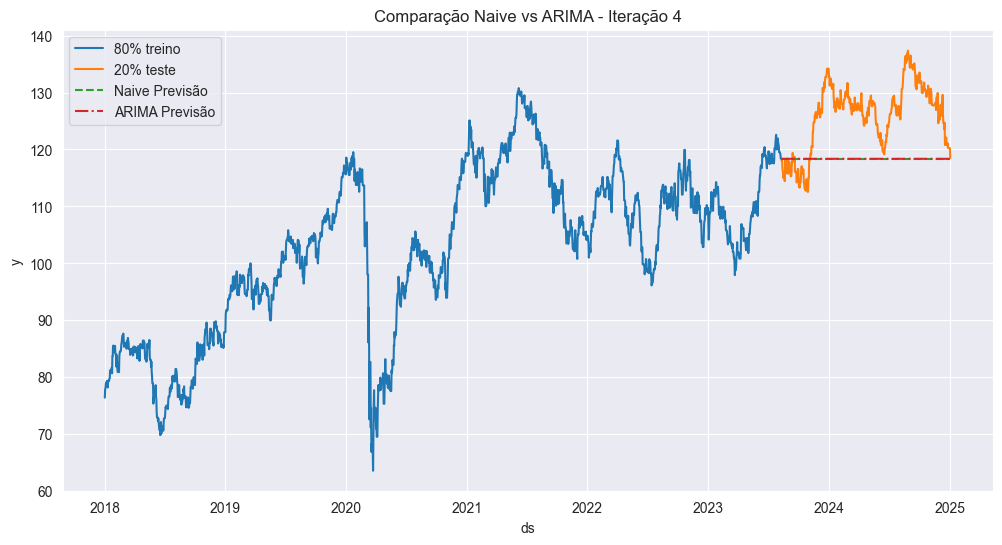

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 5
Naive - MAE: 3.41, Acurácia: 97.33%, WMAPE: 2.67%
ARIMA - MAE: 3.40, Acurácia: 97.34%, WMAPE: 2.66%
--------------------------------------------------
Previsão para o próximo dia (Naive): 126.74
Previsão para o próximo dia (ARIMA): 126.78


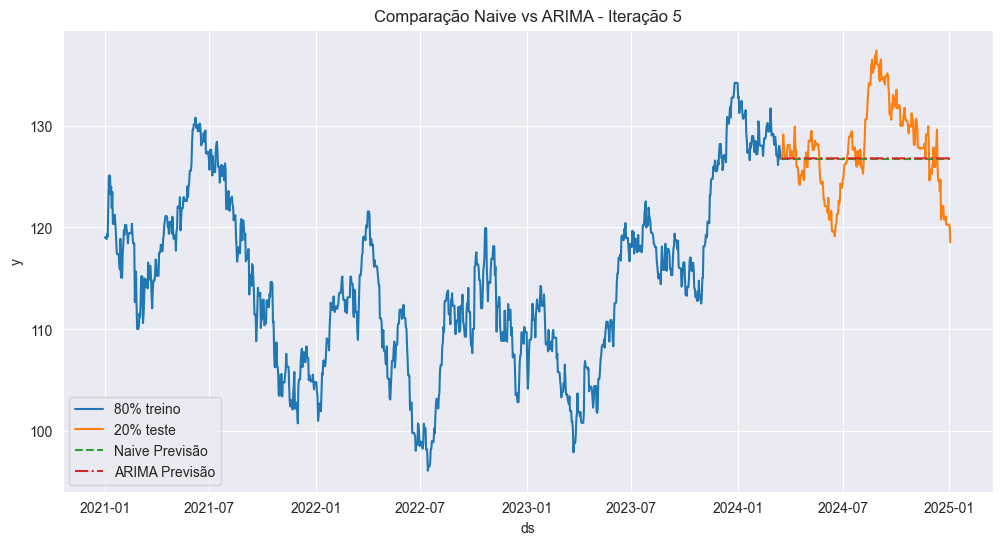

In [49]:
# Iteração sobre os conjuntos de treino e teste
for i, (df_train, df_test) in enumerate(dfs):
    # Modelo Naive
    last_observed = df_train['y'].iloc[-1]
    df_test['naive_forecast'] = last_observed  # Previsões Naive

    # Modelo ARIMA
    try:
        # Ajustar o modelo ARIMA (parâmetros p, d, q escolhidos manualmente)
        model = ARIMA(df_train['y'], order=(1, 1, 1))  # Ajuste os parâmetros (p, d, q) conforme necessário
        arima_fit = model.fit()
        
        # Prever para o conjunto de teste
        forecast_arima = arima_fit.forecast(steps=len(df_test))
        df_test['arima_forecast'] = forecast_arima.values
    except Exception as e:
        print(f"Erro ao ajustar o ARIMA na iteração {i+1}: {e}")
        df_test['arima_forecast'] = np.nan

    # Cálculo de métricas para Naive
    mae_naive = mean_absolute_error(df_test['y'], df_test['naive_forecast'])
    wmape_naive = (np.sum(np.abs(df_test['y'] - df_test['naive_forecast'])) / np.sum(df_test['y'])) * 100
    acuracia_naive = (1 - (mae_naive / df_test['y'].mean())) * 100

    # Cálculo de métricas para ARIMA
    mae_arima = mean_absolute_error(df_test['y'], df_test['arima_forecast'])
    wmape_arima = (np.sum(np.abs(df_test['y'] - df_test['arima_forecast'])) / np.sum(df_test['y'])) * 100
    acuracia_arima = (1 - (mae_arima / df_test['y'].mean())) * 100

    # Exibir resultados
    print(f"Iteração {i+1}")
    print(f"Naive - MAE: {mae_naive:.2f}, Acurácia: {acuracia_naive:.2f}%, WMAPE: {wmape_naive:.2f}%")
    print(f"ARIMA - MAE: {mae_arima:.2f}, Acurácia: {acuracia_arima:.2f}%, WMAPE: {wmape_arima:.2f}%")
    print("-" * 50)

     # Exibir o número da previsão
    print(f"Previsão para o próximo dia (Naive): {df_test['naive_forecast'].iloc[-1]:.2f}")
    print(f"Previsão para o próximo dia (ARIMA): {df_test['arima_forecast'].iloc[-1]:.2f}")
    
    # Gráficos comparativos
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=df_train, x='ds', y='y', label='80% treino', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='20% teste', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='naive_forecast', label='Naive Previsão', linestyle='--', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='arima_forecast', label='ARIMA Previsão', linestyle='-.', ax=ax)
    ax.set_title(f'Comparação Naive vs ARIMA - Iteração {i+1}')
    ax.legend()
    plt.show()


In [41]:
%pip install prophet

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.3 MB 25.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 25.4 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/13.3 MB 3.5 MB/s eta 0:00:04
   ---------------------------- ----------- 9.4/13.3 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 12.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 31.0 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:13 - cmdstanpy - INFO - Chain [1] done processing


Iteração 1
Prophet - MAE: 14.85, Acurácia: 87.34%, WMAPE: 12.66%
--------------------------------------------------
Previsão para o próximo dia (Prophet): 150.97


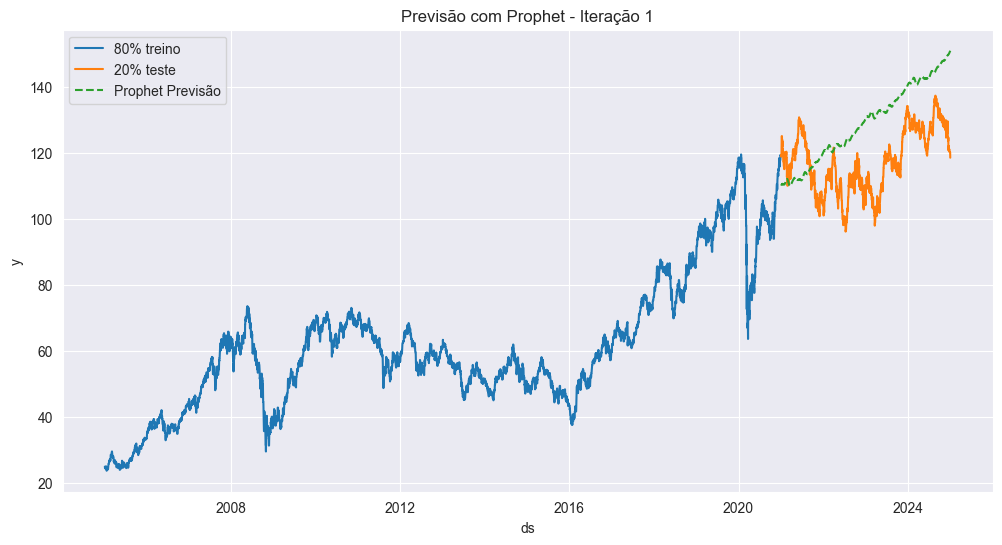

12:59:14 - cmdstanpy - INFO - Chain [1] start processing
12:59:17 - cmdstanpy - INFO - Chain [1] done processing


Iteração 2
Prophet - MAE: 22.49, Acurácia: 80.71%, WMAPE: 19.29%
--------------------------------------------------
Previsão para o próximo dia (Prophet): 160.57


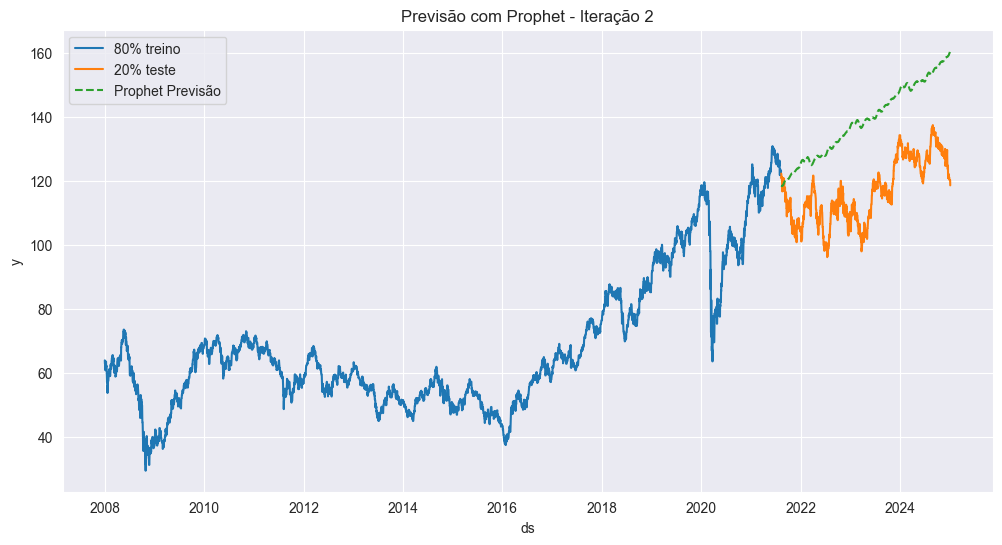

12:59:18 - cmdstanpy - INFO - Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing


Iteração 3
Prophet - MAE: 10.84, Acurácia: 90.94%, WMAPE: 9.06%
--------------------------------------------------
Previsão para o próximo dia (Prophet): 112.22


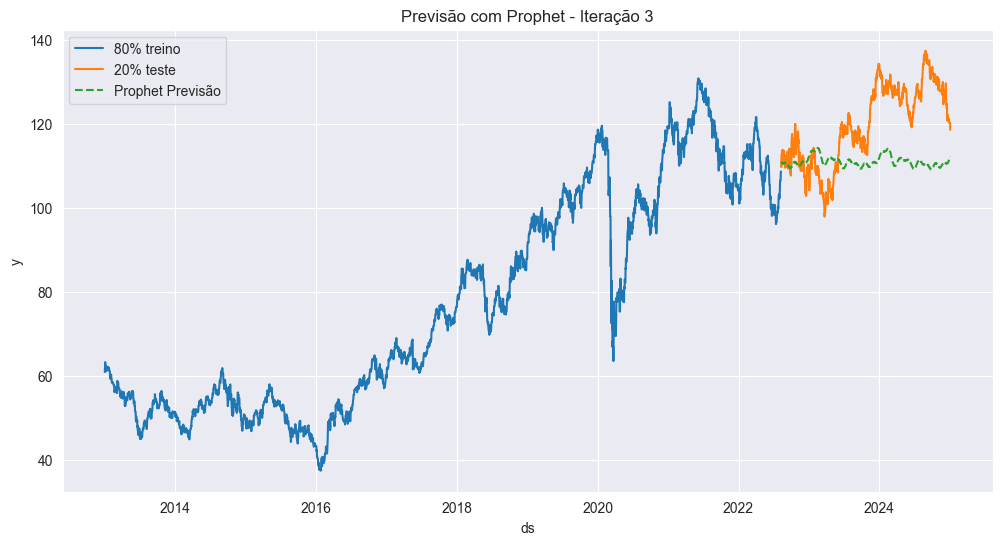

12:59:20 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing


Iteração 4
Prophet - MAE: 10.63, Acurácia: 91.55%, WMAPE: 8.45%
--------------------------------------------------
Previsão para o próximo dia (Prophet): 119.95


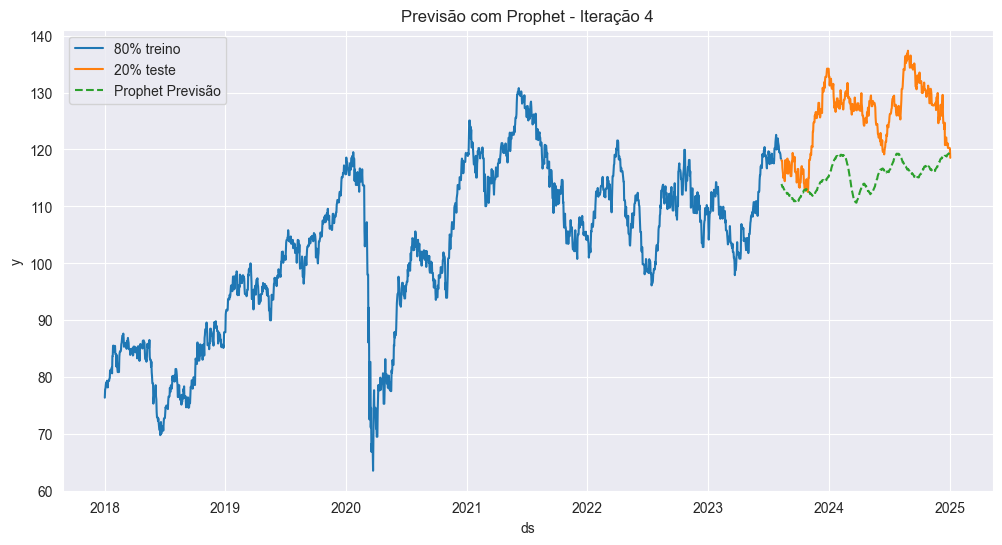

12:59:22 - cmdstanpy - INFO - Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1] done processing


Iteração 5
Prophet - MAE: 16.65, Acurácia: 86.97%, WMAPE: 13.03%
--------------------------------------------------
Previsão para o próximo dia (Prophet): 157.73


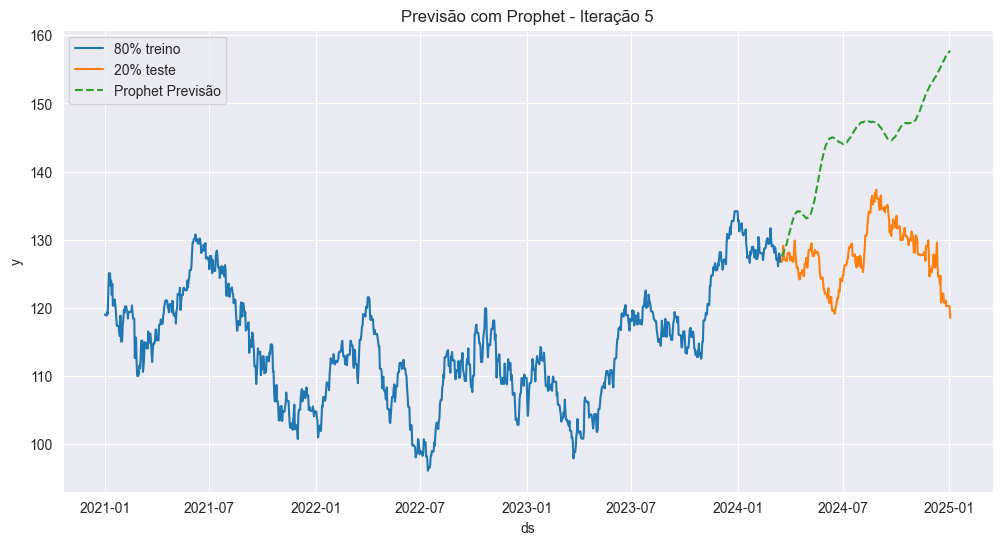

In [51]:
from prophet import Prophet

# Iteração sobre os conjuntos de treino e teste
for i, (df_train, df_test) in enumerate(dfs):
    # Preparar os dados para Prophet
    df_train_prophet = df_train.rename(columns={'ds': 'ds', 'y': 'y'})  # Prophet já aceita 'ds' e 'y'
    
    # Criar e ajustar o modelo Prophet
    model = Prophet()
    model.fit(df_train_prophet)
    
    # Criar DataFrame para previsões
    future = pd.DataFrame({'ds': df_test['ds']})
    
    # Fazer previsões
    forecast = model.predict(future)
    df_test['prophet_forecast'] = forecast['yhat'].values

    # Calcular métricas para Prophet
    mae_prophet = mean_absolute_error(df_test['y'], df_test['prophet_forecast'])
    wmape_prophet = (np.sum(np.abs(df_test['y'] - df_test['prophet_forecast'])) / np.sum(df_test['y'])) * 100
    acuracia_prophet = (1 - (mae_prophet / df_test['y'].mean())) * 100

    # Exibir resultados
    print(f"Iteração {i+1}")
    print(f"Prophet - MAE: {mae_prophet:.2f}, Acurácia: {acuracia_prophet:.2f}%, WMAPE: {wmape_prophet:.2f}%")
    print("-" * 50)
     # Exibir o número da previsão
    print(f"Previsão para o próximo dia (Prophet): {df_test['prophet_forecast'].iloc[-1]:.2f}")

    # Gráficos comparativos
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=df_train, x='ds', y='y', label='80% treino', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='20% teste', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='prophet_forecast', label='Prophet Previsão', linestyle='--', ax=ax)
    ax.set_title(f'Previsão com Prophet - Iteração {i+1}')
    ax.legend()
    plt.show()


12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing


Iteração 1
Naive - MAE: 8.03, Acurácia: 93.15%, WMAPE: 6.85%
ARIMA - MAE: 8.03, Acurácia: 93.15%, WMAPE: 6.85%
Prophet - MAE: 14.85, Acurácia: 87.34%, WMAPE: 12.66%
--------------------------------------------------
Previsão para o próximo dia (Naive): 119.02
Previsão para o próximo dia (ARIMA): 119.02
Previsão para o próximo dia (Prophet): 150.97
--------------------------------------------------


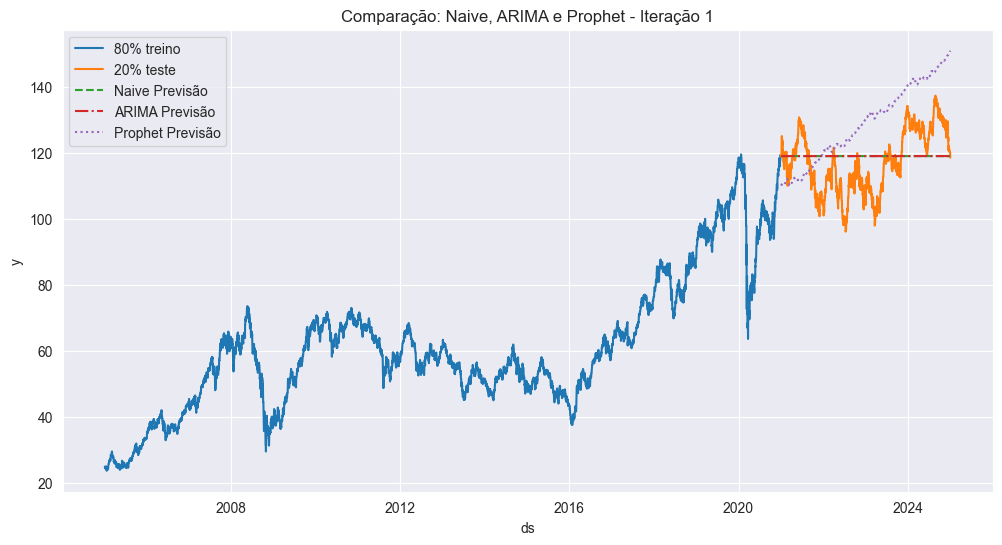

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 2
Naive - MAE: 9.99, Acurácia: 91.43%, WMAPE: 8.57%
ARIMA - MAE: 9.99, Acurácia: 91.43%, WMAPE: 8.57%
Prophet - MAE: 22.49, Acurácia: 80.71%, WMAPE: 19.29%
--------------------------------------------------
Previsão para o próximo dia (Naive): 123.02
Previsão para o próximo dia (ARIMA): 123.00
Previsão para o próximo dia (Prophet): 160.57
--------------------------------------------------


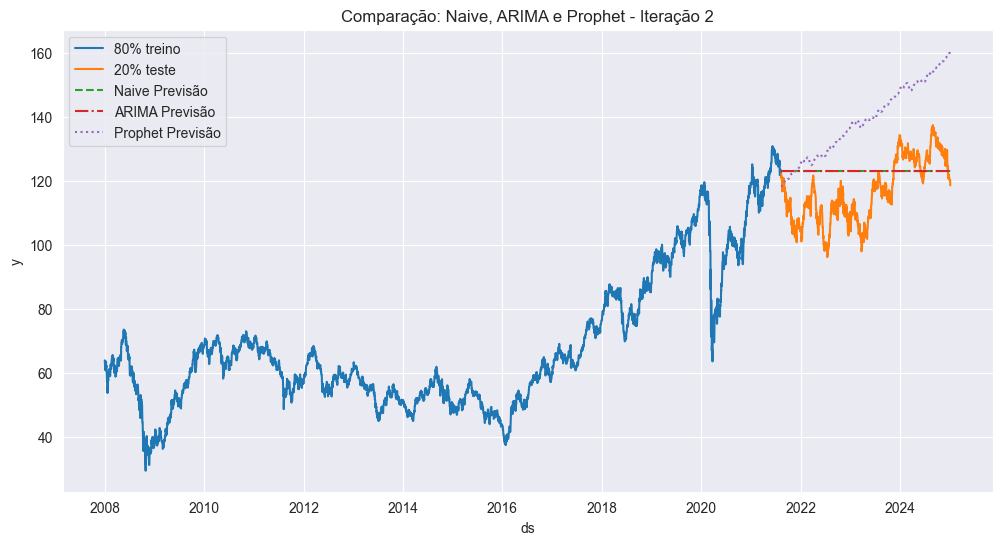

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 3
Naive - MAE: 12.03, Acurácia: 89.94%, WMAPE: 10.06%
ARIMA - MAE: 12.06, Acurácia: 89.92%, WMAPE: 10.08%
Prophet - MAE: 10.84, Acurácia: 90.94%, WMAPE: 9.06%
--------------------------------------------------
Previsão para o próximo dia (Naive): 108.65
Previsão para o próximo dia (ARIMA): 108.61
Previsão para o próximo dia (Prophet): 112.22
--------------------------------------------------


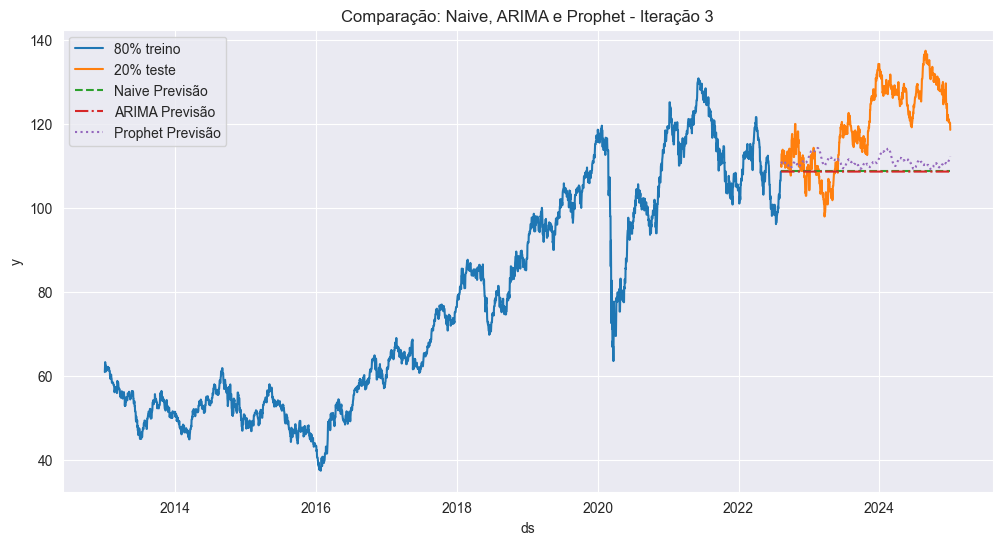

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 4
Naive - MAE: 8.36, Acurácia: 93.36%, WMAPE: 6.64%
ARIMA - MAE: 8.35, Acurácia: 93.36%, WMAPE: 6.64%
Prophet - MAE: 10.63, Acurácia: 91.55%, WMAPE: 8.45%
--------------------------------------------------
Previsão para o próximo dia (Naive): 118.35
Previsão para o próximo dia (ARIMA): 118.36
Previsão para o próximo dia (Prophet): 119.95
--------------------------------------------------


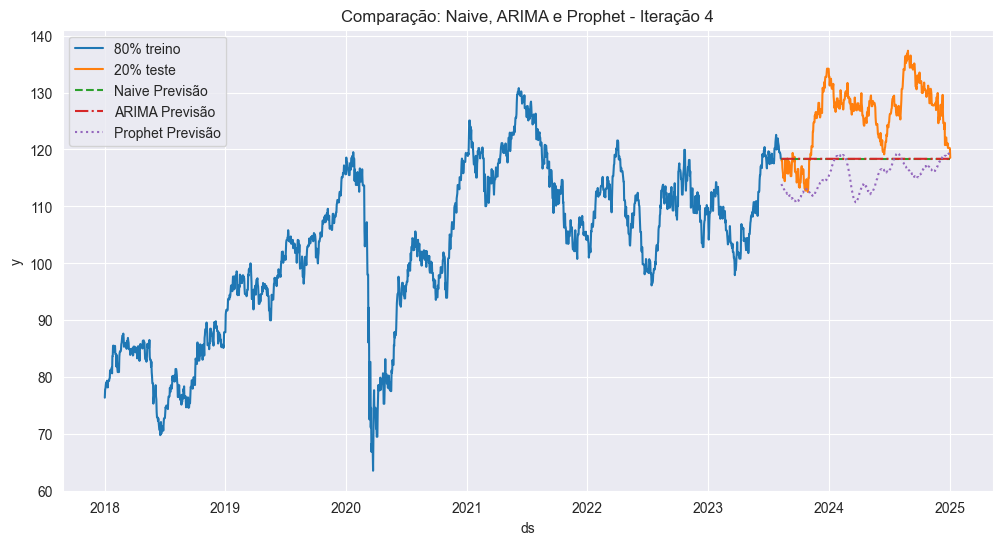

c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\kelvyn.candido\AppData

Iteração 5
Naive - MAE: 3.41, Acurácia: 97.33%, WMAPE: 2.67%
ARIMA - MAE: 3.40, Acurácia: 97.34%, WMAPE: 2.66%
Prophet - MAE: 16.65, Acurácia: 86.97%, WMAPE: 13.03%
--------------------------------------------------
Previsão para o próximo dia (Naive): 126.74
Previsão para o próximo dia (ARIMA): 126.78
Previsão para o próximo dia (Prophet): 157.73
--------------------------------------------------


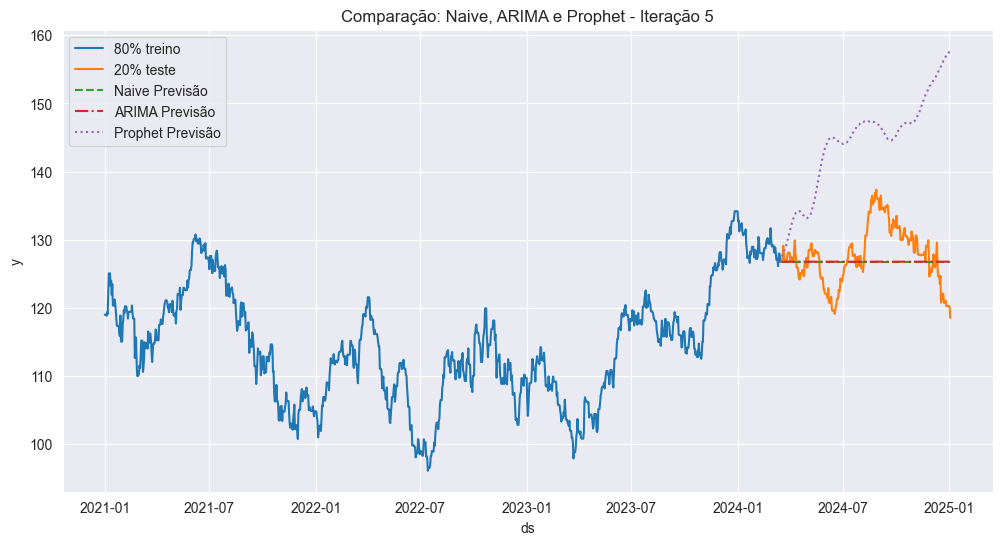

In [47]:
# Iteração sobre os conjuntos de treino e teste
for i, (df_train, df_test) in enumerate(dfs):
    # Modelo Naive
    last_observed = df_train['y'].iloc[-1]
    df_test['naive_forecast'] = last_observed  # Previsões Naive

    # Modelo ARIMA
    try:
        # Ajustar o modelo ARIMA (parâmetros p, d, q escolhidos manualmente)
        model_arima = ARIMA(df_train['y'], order=(1, 1, 1))  # Ajuste os parâmetros (p, d, q) conforme necessário
        arima_fit = model_arima.fit()
        forecast_arima = arima_fit.forecast(steps=len(df_test))
        df_test['arima_forecast'] = forecast_arima.values
    except Exception as e:
        print(f"Erro ao ajustar o ARIMA na iteração {i+1}: {e}")
        df_test['arima_forecast'] = np.nan

    # Modelo Prophet
    try:
        df_train_prophet = df_train.rename(columns={'ds': 'ds', 'y': 'y'})  # Preparar dados para Prophet
        model_prophet = Prophet()
        model_prophet.fit(df_train_prophet)
        future = pd.DataFrame({'ds': df_test['ds']})
        forecast_prophet = model_prophet.predict(future)
        df_test['prophet_forecast'] = forecast_prophet['yhat'].values
    except Exception as e:
        print(f"Erro ao ajustar o Prophet na iteração {i+1}: {e}")
        df_test['prophet_forecast'] = np.nan

    # Calcular métricas para cada modelo
    metrics = {}
    for model, forecast_column in [('Naive', 'naive_forecast'), 
                                   ('ARIMA', 'arima_forecast'), 
                                   ('Prophet', 'prophet_forecast')]:
        mae = mean_absolute_error(df_test['y'], df_test[forecast_column])
        wmape = (np.sum(np.abs(df_test['y'] - df_test[forecast_column])) / np.sum(df_test['y'])) * 100
        acuracia = (1 - (mae / df_test['y'].mean())) * 100
        metrics[model] = {'MAE': mae, 'WMAPE': wmape, 'Acurácia': acuracia}

    # Exibir resultados
    print(f"Iteração {i+1}")
    for model, values in metrics.items():
        print(f"{model} - MAE: {values['MAE']:.2f}, Acurácia: {values['Acurácia']:.2f}%, WMAPE: {values['WMAPE']:.2f}%")
    print("-" * 50)

    # Exibir o número da previsão
    print(f"Previsão para o próximo dia (Naive): {df_test['naive_forecast'].iloc[-1]:.2f}")
    print(f"Previsão para o próximo dia (ARIMA): {df_test['arima_forecast'].iloc[-1]:.2f}")
    print(f"Previsão para o próximo dia (Prophet): {df_test['prophet_forecast'].iloc[-1]:.2f}")
    print("-" * 50)
    # Gráficos comparativos
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=df_train, x='ds', y='y', label='80% treino', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='20% teste', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='naive_forecast', label='Naive Previsão', linestyle='--', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='arima_forecast', label='ARIMA Previsão', linestyle='-.', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='prophet_forecast', label='Prophet Previsão', linestyle=':', ax=ax)
    ax.set_title(f'Comparação: Naive, ARIMA e Prophet - Iteração {i+1}')
    ax.legend()
    plt.show()
   


# Conclusão

A análise exploratória e preditiva dos dados históricos do Ibovespa revelou insights valiosos sobre o comportamento do mercado financeiro brasileiro e a eficácia de diferentes modelos de previsão de séries temporais. Os principais resultados e conclusões são:

## Eficácia dos Modelos de Séries Temporais

O estudo demonstrou a superioridade dos modelos de séries temporais, particularmente o ARIMA, na previsão dos valores de fechamento do Ibovespa. A abordagem metodológica, incluindo a transformação e decomposição da série temporal, foi fundamental para identificar tendências, sazonalidades e padrões gerais nos dados.

## Desempenho Comparativo dos Modelos

1. **ARIMA**: Destacou-se como o modelo mais eficaz, apresentando:
   - MAE (Erro Absoluto Médio): 3,40
   - WMAPE (Erro Percentual Absoluto Médio Ponderado): 2,66%
   - Acurácia: 97,34%

2. **Naive**: Teve um desempenho ligeiramente inferior ao ARIMA, com resultados muito próximos.

3. **Prophet**: Apresentou desempenho significativamente inferior no contexto específico analisado.

## Importância da Escolha do Modelo

A superioridade do ARIMA neste estudo ressalta sua flexibilidade e precisão em séries com padrões bem definidos. No entanto, é importante notar que cada modelo tem suas forças específicas:

- O ARIMA é particularmente eficaz para séries temporais com tendências ou sazonalidades lineares.
- O Prophet, embora menos preciso neste caso, pode ser valioso para séries com padrões sazonais complexos ou dados faltantes.

## Implicações para Análise de Mercado

Os resultados obtidos têm implicações significativas para a análise do mercado financeiro brasileiro:

1. **Previsibilidade**: A alta acurácia do modelo ARIMA sugere um grau considerável de previsibilidade no comportamento do Ibovespa.

2. **Tomada de Decisão**: A capacidade de prever com precisão os valores de fechamento pode auxiliar investidores e analistas em suas estratégias de mercado.

3. **Análise de Risco**: A compreensão dos padrões e tendências do Ibovespa pode contribuir para uma melhor avaliação de riscos no mercado brasileiro.

## Considerações Finais

Este estudo ressalta a importância de uma análise detalhada e da seleção criteriosa de modelos para a previsão de séries temporais financeiras. A abordagem utilizada, combinando análise exploratória robusta com modelagem preditiva avançada, oferece uma base sólida para decisões baseadas em dados no contexto do mercado financeiro brasileiro.
